# Combination

In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
import finnhub
import matplotlib.dates as mpl_dates
import numpy as np
from datetime import *

In [4]:
def get_optimum_clusters(df, saturation_point = 0.05):
    '''
    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers
    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []
    labels = []

    size = min(21, df.shape[0])
    for i in range(1, size):
        # kmeans = KMeans(n_clusters = i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans = KMeans(n_clusters = i, init='random', max_iter=300, n_init=10)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_) # Sum of squared distances of samples to their Closest cluster center
        k_models.append(kmeans)
        labels.append(kmeans.labels_)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    # print("Optimum K is " + str(optimum_k + 1))
    optimum_clusters = k_models[optimum_k]
    labels = labels[optimum_k]

    return (optimum_clusters.cluster_centers_, labels)

def isSupport(df,i):
    support = df['Low'][i] < df['Low'][i-1]  and df['Low'][i] < df['Low'][i+1] \
    and df['Low'][i+1] < df['Low'][i+2] and df['Low'][i-1] < df['Low'][i-2]
    return support

def isResistance(df,i):
    resistance = df['High'][i] > df['High'][i-1]  and df['High'][i] > df['High'][i+1] \
    and df['High'][i+1] > df['High'][i+2] and df['High'][i-1] > df['High'][i-2] 
    return resistance

In [5]:
# Setup client
finnhub_client = finnhub.Client(api_key = "bt3efpf48v6tfcs816eg")

# Stock candles
ticker = 'AAPL'
start_time = int(datetime(2020, 6, 18, 0, 0).replace(tzinfo = timezone.utc).timestamp())
end_time = int(datetime(2021, 6, 18, 0, 0).replace(tzinfo = timezone.utc).timestamp())
res = finnhub_client.stock_candles(ticker, 'D', start_time, end_time)

stock = pd.DataFrame(res)
stock = stock.rename(columns = {'t':'Date', 'o':'Open', 'h':'High', 'l':'Low', 'c':'Close', 's':'status', 'v':'volumn'})
stock['Date'] = pd.to_datetime(stock['Date'], unit = 's')
stock = stock.set_index('Date')

In [6]:
sup_pr = []
res_pr= []
levels = []
for i in range(2, stock.shape[0]-2):
    if isSupport(stock,i):
        l = stock['Low'][i]
        sup_pr.append((i,l))
        levels.append((i,l))

    elif isResistance(stock,i):
        l = stock['High'][i]
        res_pr.append((i,l))
        levels.append((i,l))
        
stock['Date'] = pd.to_datetime(stock.index)
stock['Date'] = stock['Date'].apply(mpl_dates.date2num)
stock = stock.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]

xmin_sup_pr = []
xmax_sup_pr = []
for support in sup_pr:
    xmin_sup_pr.append(stock.Date[max(0, support[0] - 10)])
    xmax_sup_pr.append(stock.Date[min(support[0] + 10, stock.shape[0])])

xmin_res_pr = []
xmax_res_pr = []
for resistance in res_pr:
    xmin_res_pr.append(stock.Date[max(0, resistance[0] - 10)])
    xmax_res_pr.append(stock.Date[min(resistance[0] + 10, stock.shape[0])])

In [10]:
res = pd.DataFrame({'res': np.array(res_pr)[:,1], 'xmin': xmin_res_pr, 'xmax': xmax_res_pr})
sup = pd.DataFrame({'sup': np.array(sup_pr)[:,1], 'xmin': xmin_sup_pr, 'xmax': xmax_sup_pr})

In [12]:
res

res     xmin     xmax
0   18431.0  18431.0  18451.0
1   18450.0  18450.0  18478.0
2   18463.0  18463.0  18491.0
3   18493.0  18493.0  18522.0
4   18505.0  18505.0  18534.0
5   18534.0  18534.0  18562.0
6   18590.0  18590.0  18619.0
7   18599.0  18599.0  18631.0
8   18610.0  18610.0  18640.0
9   18619.0  18619.0  18652.0
10  18674.0  18674.0  18702.0
11  18688.0  18688.0  18716.0
12  18695.0  18695.0  18724.0

In [13]:
# set plot parameters
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)

fig, ax = plt.subplots()
candlestick_ohlc(ax, stock.values, width=0.6,\
                 colorup='green', colordown='red', alpha=0.8)
date_format = mpl_dates.DateFormatter('%d %b %Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()

for i in range(len(res)):
    plt.hlines(res.res[i], xmin = res.xmin[i], xmax = res.xmax[i], color = 'red')
    plt.text(x = res.xmin[i], y = res.res[i] + 1, s = str(res.res[i]))
    
for i in range(len(sup)):
    plt.hlines(sup.sup[i], xmin = sup.xmin[i], xmax = sup.xmax[i], color = 'green')
    plt.text(x = sup.xmin[i], y = sup.sup[i] - 2, s = str(sup.sup[i]))
    
_ = plt.title('Combination_nonfiltered')

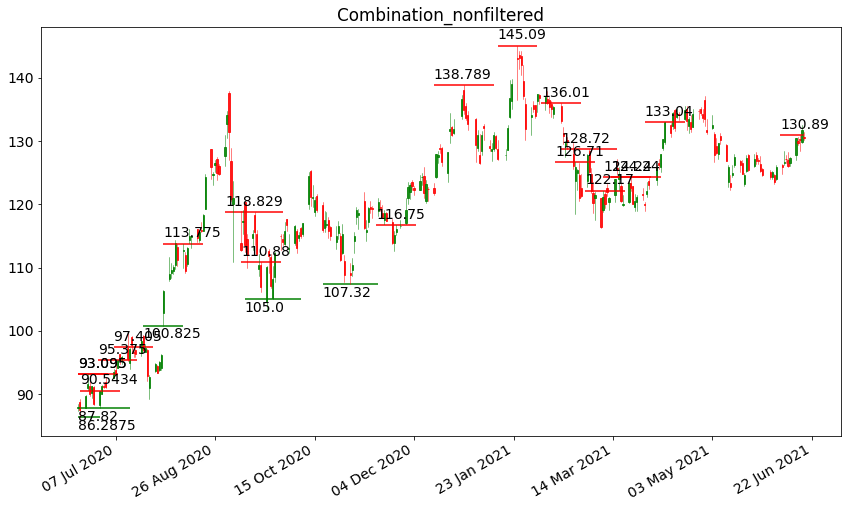

In [129]:
# import itertools

# res_sort = res.sort_values(by = 'res')
# sup_sort = sup.sort_values(by = 'sup')

# s =  np.mean(stock['High'] - stock['Low'])
# def isFarFromLevel(l):
#     return np.sum([abs(l-x) < s/60  for x in levels]) == 0

# res_temp = []
# sup_temp = []
# levels = []
# for i in itertools.zip_longest(res_sort['res'], sup_sort['sup']):
#     r = i[0]
#     s = i[1]
#     if (r != None):
#         if isFarFromLevel(r):
#             res_temp.append(r)
#             levels.append(r)
#     if (s != None):
#         if (isFarFromLevel(s)):
#             sup_temp.append(s)
#             levels.append(s)

# res_test = (res[res['res'].isin(res_temp)]).reset_index()
# sup_test = (sup[sup['sup'].isin(sup_temp)]).reset_index()

# # set plot parameters
# plt.rcParams['figure.figsize'] = [12, 7]
# plt.rc('font', size=14)

# fig, ax = plt.subplots()
# candlestick_ohlc(ax, stock.values, width=0.6,\
#                  colorup='green', colordown='red', alpha=0.8)
# date_format = mpl_dates.DateFormatter('%d %b %Y')
# ax.xaxis.set_major_formatter(date_format)
# fig.autofmt_xdate()
# fig.tight_layout()

# for i in range(len(res_test)):
#     plt.hlines(res_test.res[i], xmin = res_test.xmin[i], xmax = res_test.xmax[i], color = 'red')
#     plt.text(x = res_test.xmin[i], y = res_test.res[i] + 1, s = str(res_test.res[i]))
    
# for i in range(len(sup_test)):
#     plt.hlines(sup_test.sup[i], xmin = sup_test.xmin[i], xmax = sup_test.xmax[i], color = 'green')
#     plt.text(x = sup_test.xmin[i], y = sup_test.sup[i] - 2, s = str(sup_test.sup[i]))
    
# _ = plt.title('Combination_nonfiltered')